In [139]:
'''
5/18/16 NTZ: The Lyot dark zone definition assumes that the gray Lyot stop array will be treated
             as a binary stop following conventional rounding.
             As written presently, a translated gray Lyot stop within the nominal tolerance
             will result in some "leaked" edge regions. The LDZ definition can be
             augmented in the future.
'''
import numpy as np
#import skimage.transform
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest'
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Set basic parameters

In [226]:
overwrite = False
N = 125 # pupil array quadrant width after binning
iD = 20
oD = 80
aligntol = 5 # units of thousandths of pupil diameter
L = 1000 # starting array width
D = 1000 # starting pupil diameter
symm = 'half' # set to either 'quart' or 'half'

In [227]:
#LS_dir = os.path.abspath("../InputMasks/LS")
#LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks/LS")
LS_dir = os.path.normpath("/astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS")
if not os.path.exists(LS_dir):
    os.mkdir(LS_dir)
    print("created {:s} for LS arrays".format(LS_dir))
else:
    print("Destination {:s} already exists".format(LS_dir))

Destination /astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS already exists


## Define annular stop

In [228]:
inD = float(iD)/100
outD = float(oD)/100
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
Lyot_stop = np.ones((L,L))
Lyot_stop[inside_ann] = 0.
Lyot_stop[outside_ann] = 0.

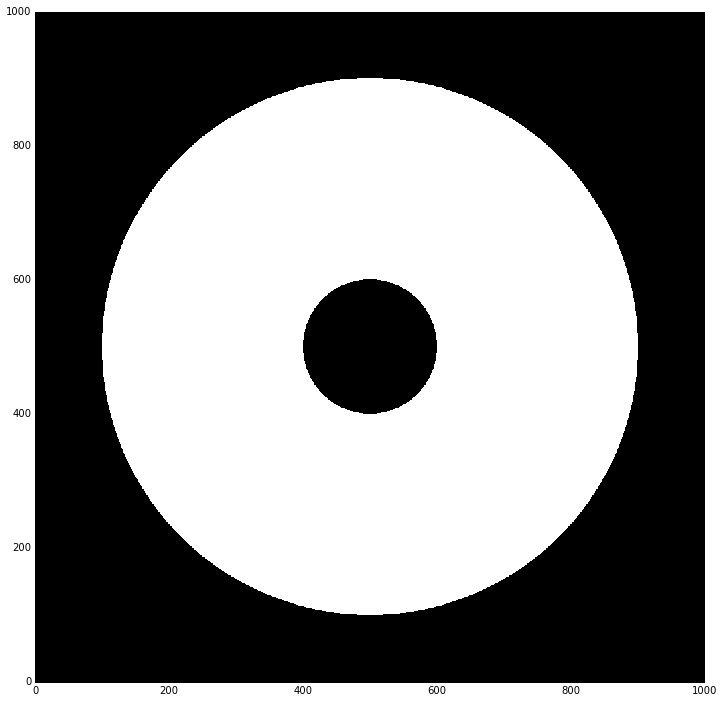

In [229]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [230]:
#scalefac = float(N)/(D/2)
#Lyot_stop_binned = skimage.transform.rescale(Lyot_stop, scalefac, order=1)

In [231]:
N_orig = D/2
scalefac = int(N_orig/N)
print("Binning the original LS array {0:d}x".format(scalefac))
Lyot_stop_binned = np.reshape(Lyot_stop, (Lyot_stop.shape[0]/scalefac, scalefac, 
                                          Lyot_stop.shape[1]/scalefac, scalefac)).mean(1).mean(2)

Binning the original LS array 4x


In [232]:
Lyot_stop.shape

(1000, 1000)

In [233]:
L_bin = Lyot_stop_binned.shape[0]
if symm is 'half':
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_half).astype(int)
    print Lyot_stop_binned_crop.shape
else:
    Lyot_stop_binned_crop = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_stop_binned_crop_binary = np.round(Lyot_stop_binned_quad).astype(int)
    print Lyot_stop_binned_crop.shape

(250, 125)


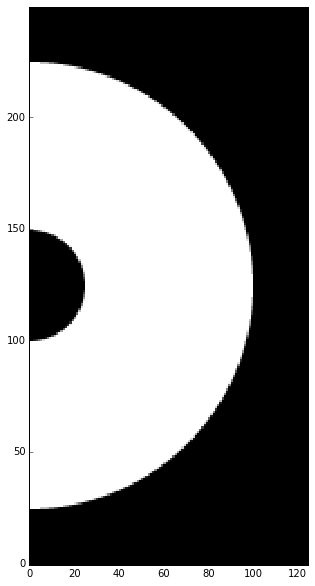

In [234]:
if symm is 'half':
    plt.figure(figsize=(20,10))
    #plt.imshow(Lyot_stop_binned_crop_binary)
    plt.imshow(Lyot_stop_binned_crop)
else:
    plt.figure(figsize=(10,10))
    plt.imshow(Lyot_stop_binned_crop)
    #plt.imshow(Lyot_stop_binned_crop_binary)

## Write the binned, cropped Lyot stop to a dat (ASCII) file 

In [235]:
if symm is 'half':
    LS_dat_fname_tail = "LS_half_ann{0:02d}D{1:02d}_clear_N{2:04d}.dat".format(
                         int(round(100*inD)), int(round(100*outD)), N)
else:
    LS_dat_fname_tail = "LS_quart_ann{0:02d}D{1:02d}_clear_N{2:04d}.dat".format(
                         int(round(100*inD)), int(round(100*outD)), N)

LS_dat_fname = os.path.join(LS_dir, LS_dat_fname_tail)

if not os.path.exists(LS_dat_fname) or overwrite==True:
    np.savetxt(LS_dat_fname, Lyot_stop_binned_crop, fmt='%.6f', delimiter=" ")
    #np.savetxt(LS_dat_fname, Lyot_stop_binned_crop_binary, fmt='%d', delimiter=" ")
    print("Wrote binned, cropped LS array to {0:s}".format(LS_dat_fname))
else:
    print("LS array {0:s} already exists, will not overwrite".format(LS_dat_fname))

Wrote binned, cropped LS array to /astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS/LS_half_ann20D80_clear_N0125.dat


In [236]:
#if os.path.exists(LS_dat_fname): os.remove(LS_dat_fname)

In [237]:
os.listdir(LS_dir)

['LS_half_ann25D80_clear_N0125.dat',
 'LS_quart_ann25D80_clear_N0125.dat',
 'LDZ_half_ann25D80_clear_Tol05_N0125.dat',
 'LDZ_quart_ann25D80_clear_Tol05_N0125.dat',
 'LS_quart_ann20D80_clear_N0125.dat',
 'LDZ_quart_ann20D80_clear_Tol05_N0125.dat',
 'LS_half_ann20D80_clear_N0125.dat']

# Define Lyot plane dark zone

In [238]:
dz_width_fac = float(aligntol)/1000              # dark zone is +/- this fraction of pupil diameter
dz_width = np.ceil(2*N*dz_width_fac).astype(int) # dark zone is +/- this number of pixels in binned pupil array
print("Lyot plane dark zone width in binned array: +/- {:d} pixels".format(dz_width))

Lyot plane dark zone width in binned array: +/- 2 pixels


## Annular component

In [239]:
L = Lyot_stop.shape[0]
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)

ann_outer_bound = np.ones(Lyot_stop.shape).astype(int)
inside = np.less_equal(Xs**2 + Ys**2, ((inD - 2*dz_width_fac)*D/2)**2)
outside = np.greater_equal(Xs**2 + Ys**2, ((outD + 2*dz_width_fac)*D/2)**2)
ann_outer_bound[inside] = 0
ann_outer_bound[outside] = 0

ann_inner_bound = np.ones(Lyot_stop.shape).astype(int)
inside = np.less_equal(Xs**2 + Ys**2, ((inD + 2*dz_width_fac)*D/2)**2)
outside = np.greater_equal(Xs**2 + Ys**2, ((outD - 2*dz_width_fac)*D/2)**2)
ann_inner_bound[inside] = 0
ann_inner_bound[outside] = 0

ann_stop = np.ones(Lyot_stop.shape).astype(int)
inside_stop = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_stop = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
ann_stop[inside] = 0
ann_stop[outside] = 0

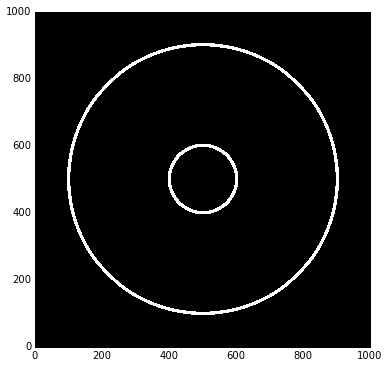

In [240]:
Lyot_dz = np.logical_xor(ann_outer_bound, ann_inner_bound)
plt.figure(figsize=(6,6))
plt.imshow(Lyot_dz)

In [241]:
#Lyot_dz_binned = skimage.transform.rescale(Lyot_dz, scalefac, order=1)

print("Binning the original LDZ array {0:d}x".format(scalefac))
Lyot_dz_binned = np.reshape(Lyot_dz, (Lyot_dz.shape[0]/scalefac, scalefac, 
                                      Lyot_dz.shape[1]/scalefac, scalefac)).mean(1).mean(2)

L_bin = Lyot_dz_binned.shape[0]
if symm is 'half':
    Lyot_dz_binned_crop = Lyot_dz_binned[L_bin/2-N:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_dz_binned_crop_binary = np.round(Lyot_dz_binned_crop).astype(int)
else:
    Lyot_dz_binned_crop = Lyot_dz_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
    Lyot_dz_binned_crop_binary = np.round(Lyot_dz_binned_crop).astype(int)
Lyot_dz_binned_crop.shape

Binning the original LDZ array 4x


(250, 125)

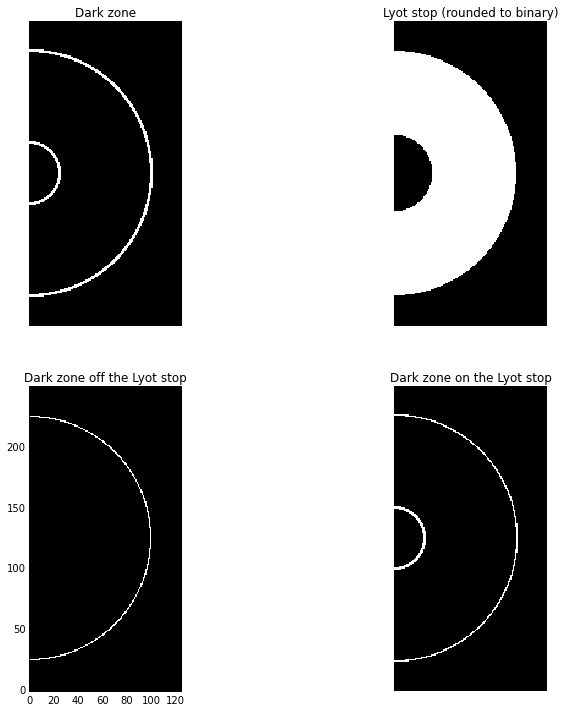

In [242]:
plt.figure(figsize=(12,12))
plt.subplot(221)
plt.title('Dark zone')
plt.imshow(Lyot_dz_binned_crop_binary)
plt.axis('off')
plt.subplot(222)
plt.title('Lyot stop (rounded to binary)')
plt.imshow(Lyot_stop_binned_crop_binary)
plt.axis('off')
plt.subplot(223)
plt.title('Dark zone off the Lyot stop')
plt.imshow(Lyot_stop_binned_crop_binary & Lyot_dz_binned_crop_binary)
plt.subplot(224)
plt.title('Dark zone on the Lyot stop')
plt.imshow(~Lyot_stop_binned_crop_binary & Lyot_dz_binned_crop_binary)
t=plt.axis('off')

## Alignment tolerance check

In [243]:
max_shift_tol = 2*N*dz_width_fac
max_shift_tol_int = int(np.floor(max_shift_tol))
test_shift = (1,0)
print("The LDZ accomomdates a translation {0:.1f}% of D={1:d} pixels = {2:.2f} pixels, up to {3:d} whole pixels".format(
      float(aligntol)/10, 2*N, max_shift_tol, max_shift_tol_int))
print("Testing an (x,y) translation of {0:} pixels. Beyond the design tolerance? {1:}".format(
      test_shift, test_shift[0]**2 + test_shift[1]**2 > max_shift_tol))
if symm is 'half':
    LS_halfplane = Lyot_stop_binned_crop_binary.copy()
else:
    LS_halfplane = np.concatenate((Lyot_stop_binned_crop_binary[::-1,:], Lyot_stop_binned_crop_binary), axis=0)    
#LS_halfplane = np.concatenate((Lyot_stop_binned_quad[::-1,:], Lyot_stop_binned_quad), axis=0)
LS_full = np.concatenate((LS_halfplane[:,::-1], LS_halfplane), axis=1)
LS_full_shift = np.roll(np.roll(LS_full, test_shift[0], axis=1), test_shift[1], axis=0)
LS_err_mask = np.ceil(np.abs(LS_full_shift - LS_full)).astype(bool)

LDZ_halfplane = np.concatenate((Lyot_dz_binned_quad_binary[::-1,:], Lyot_dz_binned_quad_binary), axis=0)
LDZ_full = np.concatenate((LDZ_halfplane[:,::-1], LDZ_halfplane), axis=1).astype(bool)

print("LDZ encompasses the LS transmission error region? {0:}".format(
        ~np.any(np.logical_and(LS_err_mask, ~LDZ_full))))

print("Total unconstrained \"leak\" area after translation = {0:d} pixels".format(
      int(np.sum(np.logical_and(LS_err_mask, ~LDZ_full)))))

The LDZ accomomdates a translation 0.5% of D=250 pixels = 1.25 pixels, up to 1 whole pixels
Testing an (x,y) translation of (1, 0) pixels. Beyond the design tolerance? False
LDZ encompasses the LS transmission error region? True
Total unconstrained "leak" area after translation = 0 pixels


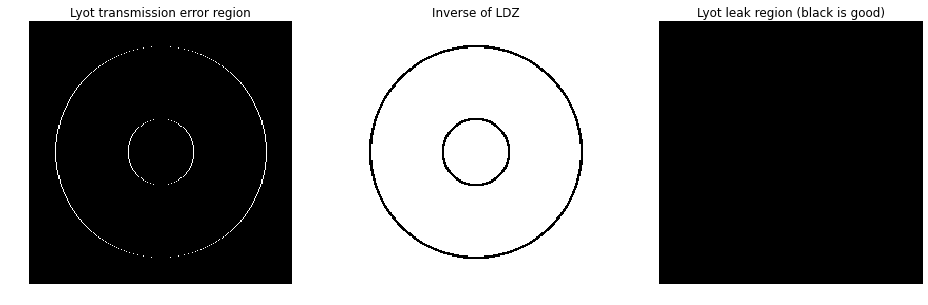

In [244]:
plt.figure(figsize=(16,6))
plt.subplot(131)
plt.imshow(LS_err_mask)
lims = plt.axis('off')
t=plt.title('Lyot transmission error region')
plt.subplot(132)
plt.imshow(~LDZ_full)
lims = plt.axis('off')
t=plt.title('Inverse of LDZ')
plt.subplot(133)
plt.imshow(np.logical_and(LS_err_mask, ~LDZ_full))
lims = plt.axis('off')
t=plt.title('Lyot leak region (black is good)')

## Write the Lyot dark zone file

In [245]:
if aligntol > 0:
    if symm is 'half':
        LDZ_dat_fname_tail = "LDZ_half_ann{0:02d}D{1:02d}_clear_Tol{2:02d}_N{3:04d}.dat".format(
                                    int(round(100*inD)), int(round(100*outD)), aligntol, N)
    else:
        LDZ_dat_fname_tail = "LDZ_quart_ann{0:02d}D{1:02d}_clear_Tol{2:02d}_N{3:04d}.dat".format(
                                    int(round(100*inD)), int(round(100*outD)), aligntol, N)
    LDZ_dat_fname = os.path.join(LS_dir, LDZ_dat_fname_tail)
    
    if not os.path.exists(LDZ_dat_fname) or overwrite==True:
        np.savetxt(LDZ_dat_fname, Lyot_dz_binned_crop_binary, fmt='%d', delimiter=" ")
        print("Wrote binned, cropped LDZ array to {0:s}".format(LDZ_dat_fname))
    else:
        print("LDZ array {0:s} already exists, will not overwrite".format(LDZ_dat_fname))

Wrote binned, cropped LDZ array to /astro/opticslab1/SCDA/Apertures/InputMasks_v2/LS/LDZ_half_ann20D80_clear_Tol05_N0125.dat


In [246]:
os.listdir(LS_dir)

['LS_half_ann25D80_clear_N0125.dat',
 'LS_quart_ann25D80_clear_N0125.dat',
 'LDZ_half_ann25D80_clear_Tol05_N0125.dat',
 'LDZ_quart_ann25D80_clear_Tol05_N0125.dat',
 'LS_quart_ann20D80_clear_N0125.dat',
 'LDZ_quart_ann20D80_clear_Tol05_N0125.dat',
 'LS_half_ann20D80_clear_N0125.dat',
 'LDZ_half_ann20D80_clear_Tol05_N0125.dat']